In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="7"

Mon Jan 22 02:43:12 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   44C    P0    47W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [4]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [5]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = -3
hp.const_sigma = False
hp.quantize = False
hp.prior_mu = 0.99

In [6]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [7]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_uniform/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 0


### Dataset

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [11]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

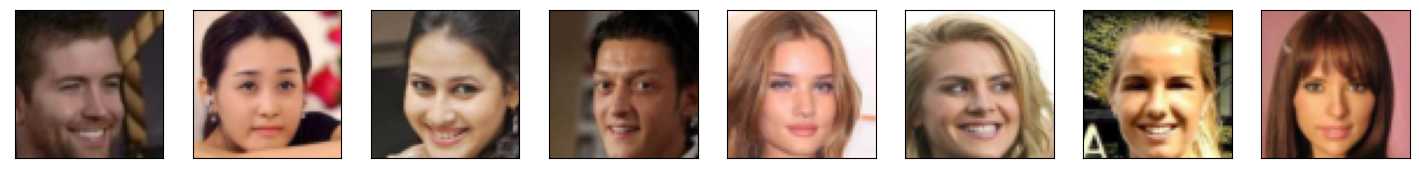

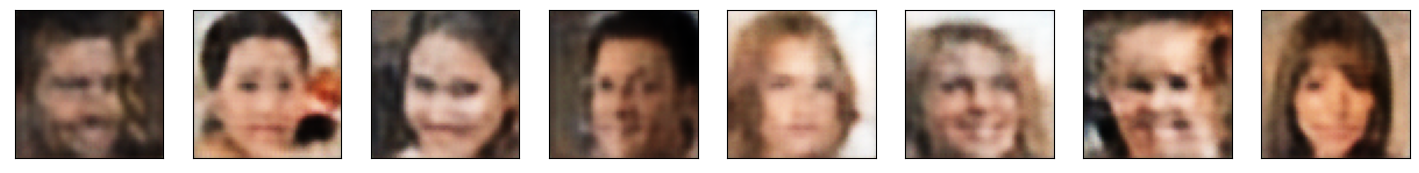

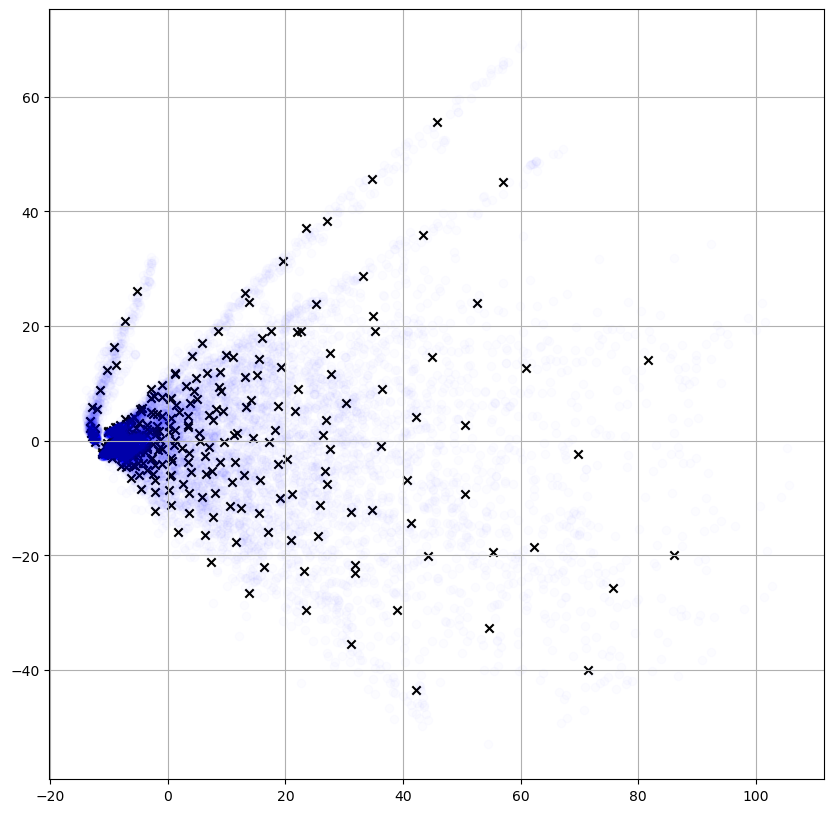

4001
lse_loss 43.00241470336914
commit_loss 0.10642348229885101
recon_loss 0.006008908152580261
4002
lse_loss 33.19377517700195
commit_loss 0.11334628611803055
recon_loss 0.005700649693608284
4003
lse_loss 32.37601089477539
commit_loss 0.10905106365680695
recon_loss 0.006470660679042339
4004
lse_loss 40.93735122680664
commit_loss 0.111434206366539
recon_loss 0.005295931361615658
4005
lse_loss 31.011341094970703
commit_loss 0.11055876314640045
recon_loss 0.0053723896853625774
4006
lse_loss 38.918766021728516
commit_loss 0.10860645025968552
recon_loss 0.0060460325330495834
4007
lse_loss 46.58662796020508
commit_loss 0.13650260865688324
recon_loss 0.005425245966762304
4008
lse_loss 39.931156158447266
commit_loss 0.11708767712116241
recon_loss 0.005479400046169758
4009
lse_loss 51.84523391723633
commit_loss 0.10903508961200714
recon_loss 0.005462624132633209
4010
lse_loss 29.643482208251953
commit_loss 0.1083507388830185
recon_loss 0.005785695742815733
4011
lse_loss 35.99917984008789
commi

lse_loss 15.660283088684082
commit_loss 0.106512650847435
recon_loss 0.005541262682527304
4087
lse_loss 24.33713150024414
commit_loss 0.12616485357284546
recon_loss 0.005536321550607681
4088
lse_loss 26.764347076416016
commit_loss 0.11161631345748901
recon_loss 0.005330660846084356
4089
lse_loss 21.641590118408203
commit_loss 0.13066068291664124
recon_loss 0.00630906131118536
4090
lse_loss 15.662434577941895
commit_loss 0.1020716205239296
recon_loss 0.005630720406770706
4091
lse_loss 26.52786636352539
commit_loss 0.11237478256225586
recon_loss 0.005597938783466816
4092
lse_loss 23.954090118408203
commit_loss 0.10964358597993851
recon_loss 0.006595219485461712
4093
lse_loss 4.417576789855957
commit_loss 0.10319139808416367
recon_loss 0.005714437924325466
4094
lse_loss 31.26553726196289
commit_loss 0.13041722774505615
recon_loss 0.005458135157823563
4095
lse_loss 26.514423370361328
commit_loss 0.10798829793930054
recon_loss 0.006458354648202658
4096
lse_loss 35.250003814697266
commit_los

4173
lse_loss 11.54576587677002
commit_loss 0.10724496841430664
recon_loss 0.0057326871901750565
4174
lse_loss 20.46799087524414
commit_loss 0.17350125312805176
recon_loss 0.006114475429058075
4175
lse_loss 20.81052017211914
commit_loss 0.11904982477426529
recon_loss 0.005801048129796982
4176
lse_loss 15.387089729309082
commit_loss 0.10479101538658142
recon_loss 0.00616417545825243
4177
lse_loss 1.165593147277832
commit_loss 0.10746428370475769
recon_loss 0.005473186727613211
4178
lse_loss -0.33530712127685547
commit_loss 0.09681279957294464
recon_loss 0.005468255840241909
4179
lse_loss 13.931736946105957
commit_loss 0.10414664447307587
recon_loss 0.005889733787626028
4180
lse_loss 7.8720293045043945
commit_loss 0.10398425161838531
recon_loss 0.005766185931861401
4181
lse_loss 11.50456714630127
commit_loss 0.1114329844713211
recon_loss 0.005958732217550278
4182
lse_loss 19.258808135986328
commit_loss 0.11174311488866806
recon_loss 0.005525992251932621
4183
lse_loss 8.153996467590332
co

lse_loss -3.577235221862793
commit_loss 0.09963496029376984
recon_loss 0.005737736821174622
4259
lse_loss 2.9779863357543945
commit_loss 0.10403458774089813
recon_loss 0.005318408366292715
4260
lse_loss 12.174687385559082
commit_loss 0.11975123733282089
recon_loss 0.0056029511615633965
4261
lse_loss 4.0670671463012695
commit_loss 0.0919598788022995
recon_loss 0.005699330475181341
4262
lse_loss -8.260096549987793
commit_loss 0.09204550087451935
recon_loss 0.005786073859781027
4263
lse_loss -4.940302848815918
commit_loss 0.10112424194812775
recon_loss 0.005495380610227585
4264
lse_loss -3.760371208190918
commit_loss 0.11028321087360382
recon_loss 0.006285649724304676
4265
lse_loss 3.130986213684082
commit_loss 0.09328047186136246
recon_loss 0.005873476155102253
4266
lse_loss 8.329792976379395
commit_loss 0.1015598326921463
recon_loss 0.005743898451328278
4267
lse_loss 1.378880500793457
commit_loss 0.11149992048740387
recon_loss 0.0060401298105716705
4268
lse_loss -4.6729230880737305
comm

lse_loss -20.668498992919922
commit_loss 0.09120648354291916
recon_loss 0.005087011959403753
4344
lse_loss -15.072596549987793
commit_loss 0.12040466070175171
recon_loss 0.005517329555004835
4345
lse_loss -23.40804672241211
commit_loss 0.10639723390340805
recon_loss 0.005712563171982765
4346
lse_loss -17.461650848388672
commit_loss 0.10317444056272507
recon_loss 0.005007239989936352
4347
lse_loss 6.068394660949707
commit_loss 0.100417360663414
recon_loss 0.006124439649283886
4348
lse_loss 0.30441761016845703
commit_loss 0.09608133137226105
recon_loss 0.005686312913894653
4349
lse_loss -11.21467113494873
commit_loss 0.10266292095184326
recon_loss 0.006085425149649382
4350
lse_loss -10.086115837097168
commit_loss 0.10165831446647644
recon_loss 0.005768056958913803
4351
lse_loss -20.68532943725586
commit_loss 0.09727282077074051
recon_loss 0.005686134099960327
4352
lse_loss -2.6136884689331055
commit_loss 0.10333697497844696
recon_loss 0.00604329165071249
4353
lse_loss -11.184748649597168

lse_loss -33.796443939208984
commit_loss 0.09407256543636322
recon_loss 0.0055148000828921795
4429
lse_loss -18.892436981201172
commit_loss 0.09194344282150269
recon_loss 0.006103088613599539
4430
lse_loss -5.8150434494018555
commit_loss 0.1092752069234848
recon_loss 0.006329978816211224
4431
lse_loss -14.524622917175293
commit_loss 0.09519274532794952
recon_loss 0.006215069442987442
4432
lse_loss -31.117382049560547
commit_loss 0.09432227909564972
recon_loss 0.005566295236349106
4433
lse_loss -19.66109848022461
commit_loss 0.08558367192745209
recon_loss 0.006300972308963537
4434
lse_loss -8.127985954284668
commit_loss 0.09758791327476501
recon_loss 0.005728345364332199
4435
lse_loss -28.14474105834961
commit_loss 0.11319820582866669
recon_loss 0.006735858973115683
4436
lse_loss -27.15969467163086
commit_loss 0.09128788113594055
recon_loss 0.005830788053572178
4437
lse_loss -13.532206535339355
commit_loss 0.11789856851100922
recon_loss 0.005769220646470785
4438
lse_loss -26.02924728393

lse_loss -20.212841033935547
commit_loss 0.09666697680950165
recon_loss 0.005899162031710148
4515
lse_loss -32.5744743347168
commit_loss 0.1058645099401474
recon_loss 0.005891458131372929
4516
lse_loss -33.886287689208984
commit_loss 0.10432539880275726
recon_loss 0.005709511693567038
4517
lse_loss -36.72123336791992
commit_loss 0.09584860503673553
recon_loss 0.005680943839251995
4518
lse_loss -40.763729095458984
commit_loss 0.08623547106981277
recon_loss 0.006171993911266327
4519
lse_loss -38.84727096557617
commit_loss 0.0982431173324585
recon_loss 0.006388894282281399
4520
lse_loss -18.780315399169922
commit_loss 0.10364159196615219
recon_loss 0.005661895032972097
4521
lse_loss -34.93906784057617
commit_loss 0.0923796221613884
recon_loss 0.005768859758973122
4522
lse_loss -43.731990814208984
commit_loss 0.09475815296173096
recon_loss 0.00525984913110733
4523
lse_loss -33.19912338256836
commit_loss 0.10372989624738693
recon_loss 0.005994539707899094
4524
lse_loss -36.7750358581543
com

4599
lse_loss -30.642955780029297
commit_loss 0.09251166880130768
recon_loss 0.005686026066541672
4600
lse_loss -49.13956832885742
commit_loss 0.08847720921039581
recon_loss 0.005755110643804073
4601
lse_loss -56.163387298583984
commit_loss 0.10076867043972015
recon_loss 0.005771797150373459
4602
lse_loss -48.54755783081055
commit_loss 0.09691167622804642
recon_loss 0.006065189838409424
4603
lse_loss -39.56673812866211
commit_loss 0.10062417387962341
recon_loss 0.006014956161379814
4604
lse_loss -49.689022064208984
commit_loss 0.08843011409044266
recon_loss 0.00605379045009613
4605
lse_loss -50.04990768432617
commit_loss 0.0888824462890625
recon_loss 0.005790458992123604
4606
lse_loss -49.69503402709961
commit_loss 0.0965622216463089
recon_loss 0.006104473955929279
4607
lse_loss -48.4940299987793
commit_loss 0.08927395939826965
recon_loss 0.005893738474696875
4608
lse_loss -43.77668380737305
commit_loss 0.08646795898675919
recon_loss 0.006519130431115627
4609
lse_loss -52.5538902282714

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')